# Traveling Salesperson Problem (TSP)

The Traveling Salesperson Problem (TSP) is a classic problem in computer science and operations research that seeks to find the shortest possible route that a salesperson can take to visit a given set of cities and return to the starting point. The problem is often formulated as a graph, where each city is represented by a node and the distances between them are represented by edges with weights. The salesperson must visit each city exactly once and return to the starting point, and the goal is to minimize the total distance traveled.
The TSP is an NP-hard problem, which means that no known algorithm can solve all instances of the problem in polynomial time. However, there are many heuristic and approximation algorithms that can find good solutions for practical instances of the problem. The TSP has many applications in logistics, transportation, and supply chain management, as well as in other fields such as genomics, where it is used to solve problems such as DNA sequencing.

This project pertains to the optimization of delivery routes for In's Supermarket truck in Rome. The objective is to identify the shortest path for the truck to transport goods from the depot to the delivery destination and subsequently return to the depot. The OpenStreetMap API is utilized to obtain accurate distance measurements between the relevant locations, and the TSP algorithm, implemented through Google OR-Tools, is employed to determine the optimal route.

### Importing libraries

In [10]:
# Import the necessary libraries
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

### Defining the location

In [2]:
# Define the city you are interested in
city = 'Rome, Roma, Lazio, Italy'

# Download the road network data for the city
graph = ox.graph_from_place(city, network_type='drive')

### Creating distance matrix by OpenStreetMap API

In [4]:
# Define a list of points which show the depot(center_point) and the 20 brach of In's Supermarcket in Rome.
center_point = (41.88193295890535, 12.619776330280022)
point_1 = (41.908621373972295, 12.451843389526827)
point_2 = (41.87601670475574, 12.46714063290324)
point_3 = (41.91145117364007, 12.50070733084591)
point_4 = (41.898347753189896, 12.513962742130182)
point_5 = (41.9089740816641, 12.526142601586148)
point_6 = (41.88157598436675, 12.515003286851687)
point_7 = (41.8831455681145, 12.524614468156614)
point_8 = (41.86632986157466, 12.527607363164517)
Point_9 = (41.898949822251915, 12.537586037153568)
point_10 = (41.8698670108551, 12.53540339880448)
point_11 = (41.880614044329306, 12.540577054594433)
point_12 = (41.881723521270324, 12.543075936516049)
point_13 = (41.91415322012547, 12.554589177418643)
point_14 = (41.90917790770905, 12.549287778654572)
Point_15 = (41.89131974745777, 12.552044411896036)
point_16 = (41.891456106812385, 12.560027651446832)
Point_17 = (41.89620530454831, 12.563819927661681)
point_18 = (41.865450064562786, 12.550454865082719)
point_19 = (41.863221244903556, 12.551379566587595)
point_20 = (41.861567455826666, 12.555502620143239)

points = [center_point, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8,
          Point_9, point_10, point_11, point_12, point_13, point_14, Point_15, point_16, Point_17,
          point_18, point_19, point_20]

# Get the nodes corresponding to the points
nodes = []
for point in points:
    node = ox.distance.nearest_nodes(graph, point[1], point[0])
    nodes.append(node)

# Calculate the distance matrix between the nodes
distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if i == j:
            distance_matrix[i, j] = 0
        elif nx.has_path(graph, nodes[i], nodes[j]):
            distance_matrix[i, j] = nx.shortest_path_length(
                graph, nodes[i], nodes[j], weight='length')
            distance_matrix[j, i] = distance_matrix[i, j]

### Plotting

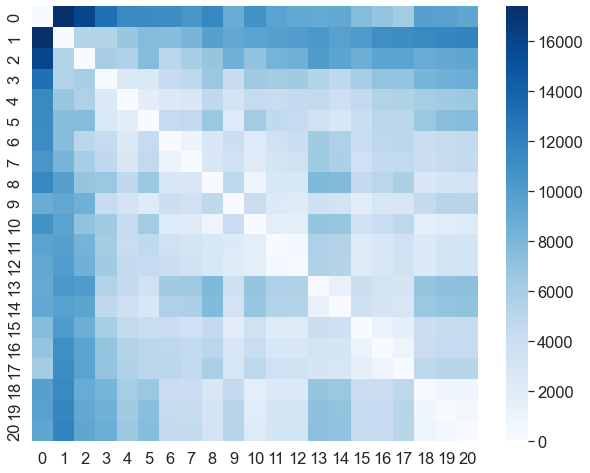

In [7]:
# plotting the heatmap of distance matrix
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))

sns.heatmap(distance_matrix, cmap="Blues")
plt.show()

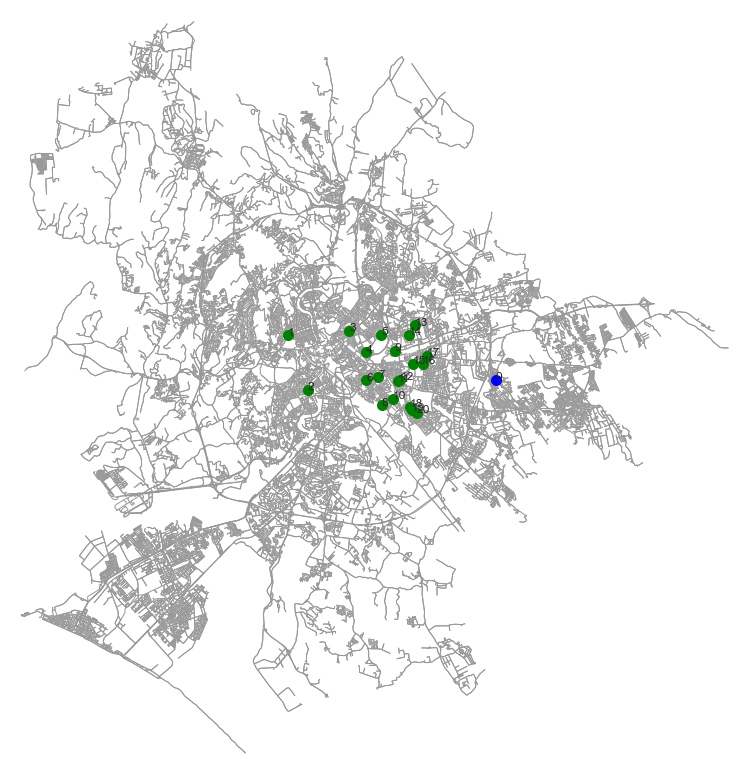

In [8]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=100, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)


ax.axis('off')
plt.show()

Here is the above map but zooming for more details.

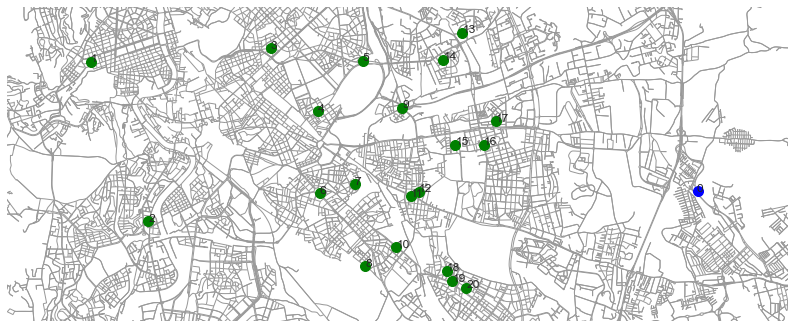

In [9]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=100, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)

ax.set_xlim(12.428, 12.645)
ax.set_ylim(41.855, 41.92)

ax.axis('off')
plt.show()

### Create the routing model

In [11]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

In [12]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

### Create the distance callback

In [13]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]


transit_callback_index = routing.RegisterTransitCallback(distance_callback)

### Set the cost of travel

In [14]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Set search parameters (PATH_CHEAPEST_ARC)

Here I choose the PATH_CHEAPEST_ARC, however you can try the other methods that are defined in: https://developers.google.com/optimization/routing/routing_options#first_solution_strategy

In [15]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

### Add the solution printer

In [18]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} meters'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(
            previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}meters\n'.format(route_distance)

### Solve and print the solution

In [19]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

Objective: 56427 meters
Route for vehicle 0:
 0 -> 16 -> 15 -> 9 -> 12 -> 11 -> 18 -> 20 -> 19 -> 10 -> 8 -> 7 -> 6 -> 2 -> 1 -> 3 -> 4 -> 5 -> 14 -> 13 -> 17 -> 0



### creating a list of route

In [20]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

In [21]:
routes = get_routes(solution, routing, manager)
# Display the routes.
for i, route in enumerate(routes):
    print('Route', i, route)

Route 0 [0, 16, 15, 9, 12, 11, 18, 20, 19, 10, 8, 7, 6, 2, 1, 3, 4, 5, 14, 13, 17, 0]


### Plotting the finall result

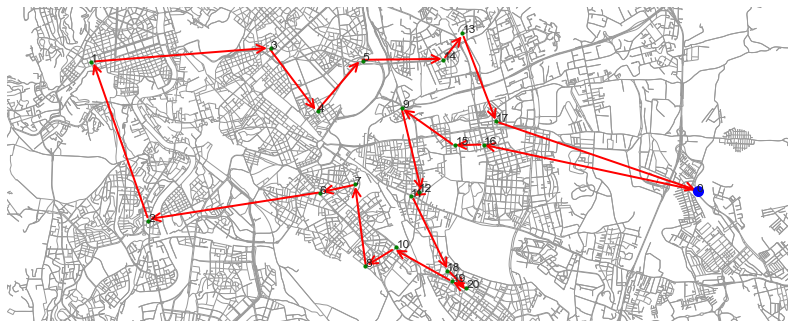

In [22]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=10, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)

# Define the order of the nodes to connect
order = route

# Plot the lines between the nodes in the specified order
for i in range(len(order) - 1):
    arrow = FancyArrowPatch((points[route[i]][1], points[route[i]][0]), (points[route[i+1]][1], points[route[i+1]][0]), arrowstyle='->', color='red', linewidth=2, mutation_scale=20)
    ax.add_patch(arrow)
    
# Set the limits of the x-axis and y-axis to zoom in on a specific part of the plot
ax.set_xlim(12.428, 12.645)
ax.set_ylim(41.855, 41.92)

ax.axis('off')
plt.show()